# Select sample and inspect chemical gradients across radial and vertical kinematics

In [9]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm 
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax

import astropy.units as u
from matplotlib.colors import LogNorm


In [2]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

554738


In [3]:
# remove GC stars
path_gc = '/Users/dhortad/Documents/Data/GC_members_VAC-v1_1.fits'
tb_gc = fits.open(path_gc)
data_gc = tb_gc[1].data
gc_stars_vac = data_gc.field('APOGEE_ID')
print('There are '+str(len(gc_stars_vac))+' GC stars')

There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
mask_gcs = np.isin(list(data['APOGEE_ID']),list(gc_stars_vac))

starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

np.int64(536530)

In [6]:
dist= data['dist50']
dist_err = (data['dist84']-data['dist16'])/2.

# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.6)&(data['TEFF']>3000.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(starflag_mask)&(aspcapflag_mask) & (dist/dist_err>5)
    # & (age_err<2)
    
print('There are '+str(len(data[mask]))+' stars in the parent sample')

There are 307304 stars in the parent sample


In [8]:
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
rads = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2+data['xyz'][:,2]**2)
vcirc = 229.-1.7*(Rgal-8.275)
vcirc2 = 250.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
Rg2 = -(data['L'][:,2]/vcirc2)
deltaR = Rgal-Rg
deltaR2 = Rgal-Rg2
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

LR = (-z*vt) 
Lphi = (z.value*vR - Rgal*vz.value) 
Lz = Rgal * vt


In [22]:
# do a selection in Mg/Mn-Al/Fe
mgmn = data['MG_FE'] - data['MN_FE']
line1 = data['AL_FE']*1.5 + 0.28
line2 = data['AL_FE']*-0.9 + 0.4

lowa_disc_mask = ((data['AL_FE']>-0.15)&(data['AL_FE']<0.05)&(mgmn<line1))|((data['AL_FE']>0.05)&(data['AL_FE']<0.3)&(mgmn<line2))
print(len(data[mask&lowa_disc_mask]))

198302


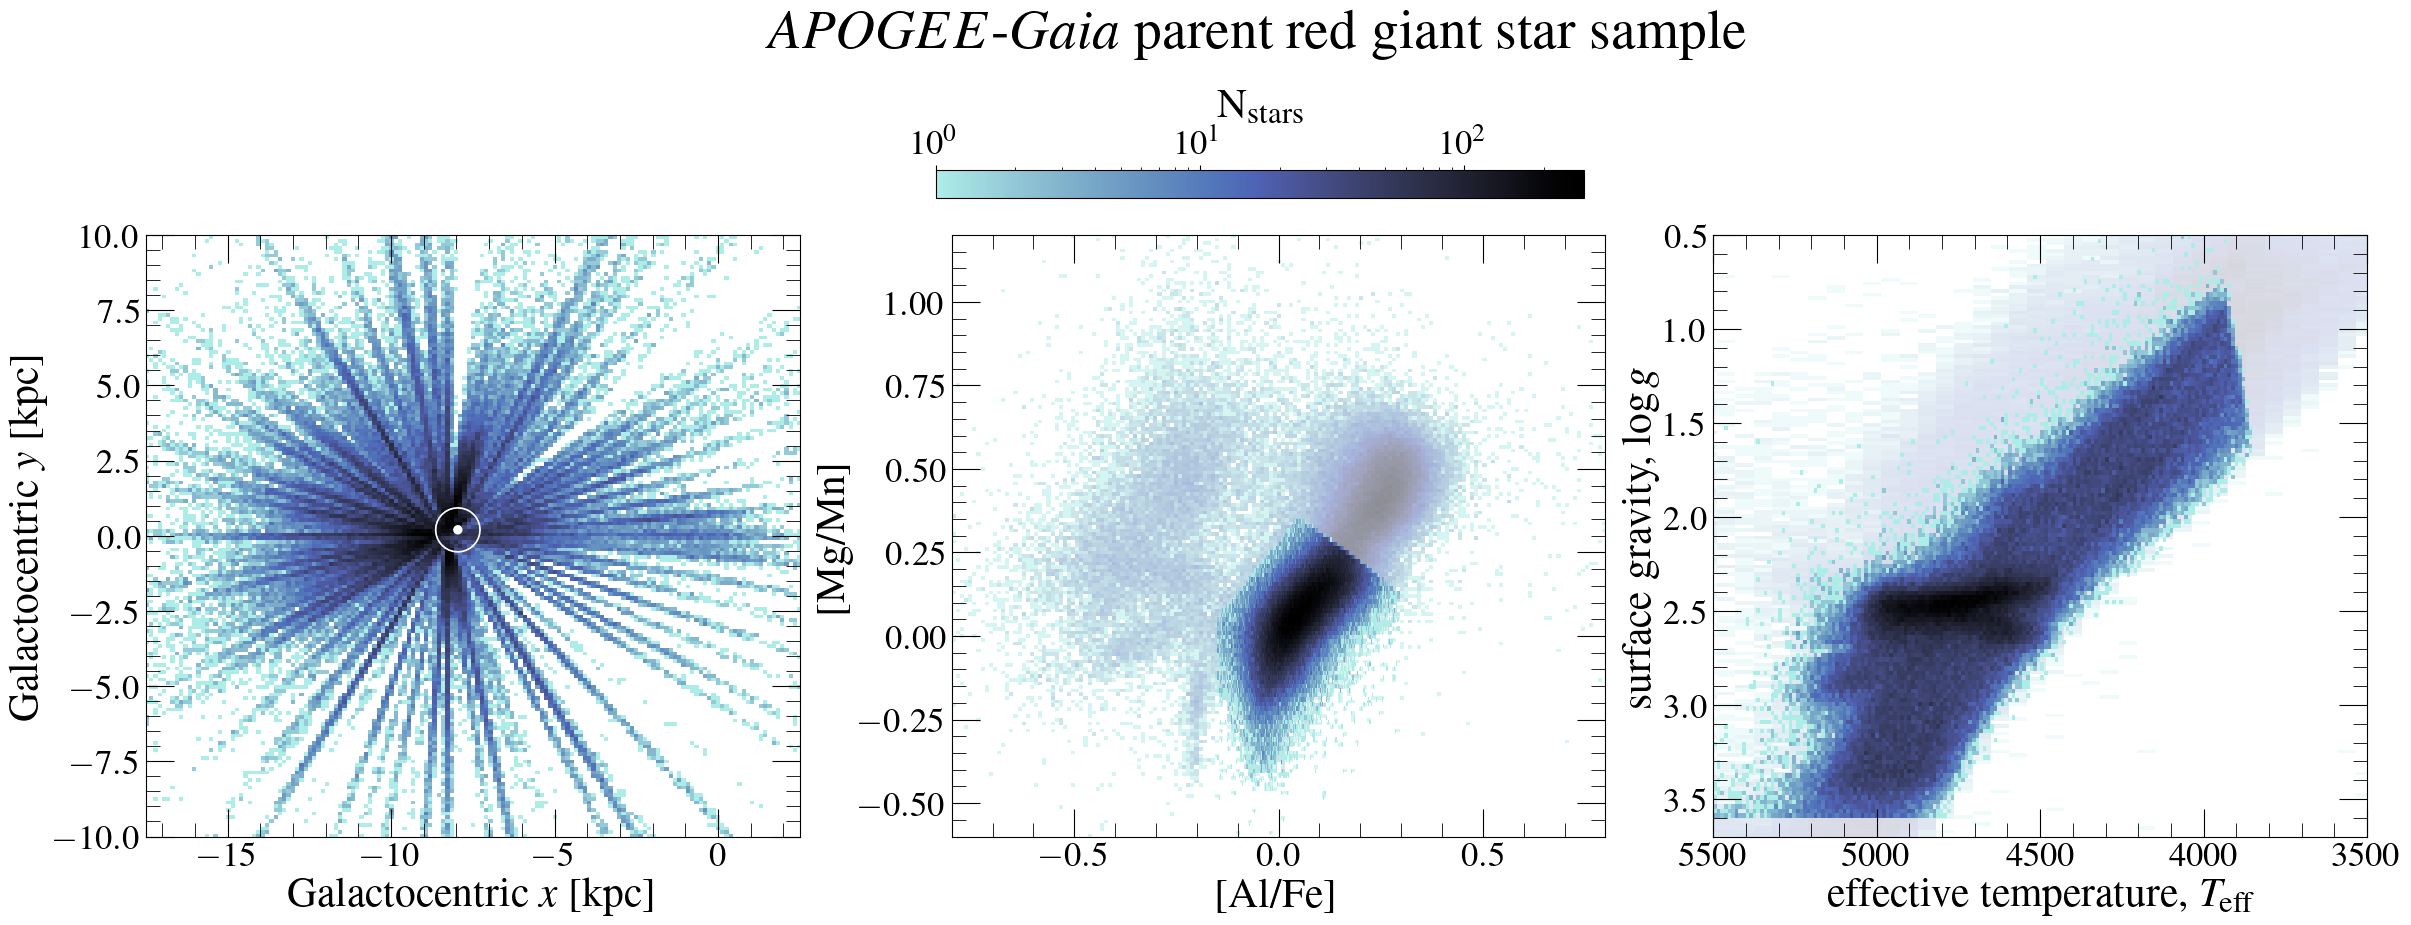

In [23]:
binns = 300
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')
fig.suptitle('$APOGEE$-$Gaia$ parent red giant star sample',fontsize=40,x=0.52,y=1.3)

plt.subplot(1,3,1)
plt.hist2d(data['xyz'][:,0][mask&lowa_disc_mask&(rads<20)],data['xyz'][:,1][mask&lowa_disc_mask&(rads<20)],bins=binns,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
# plt.scatter(-8.125,0.,c='white',s=100)
plt.text(-8.7,-0.35,'$\odot$',fontsize=50,color='white',fontweight='bold')
plt.xlabel('Galactocentric $x$ [kpc]', fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]', fontsize=30)
plt.xlim(-17.5,2.5)
plt.ylim(-10.,10.)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
# plt.title('APOGEE-$Gaia$ parent red giant star sample', fontsize=35, x=0.5,y=1.3)
plt.hist2d(data['AL_FE'][mask&(data['MN_FE']>-10)&(data['AL_FE']>-10)&(data['MG_FE']>-10)],mgmn[mask&(data['MN_FE']>-10)&(data['AL_FE']>-10)&(data['MG_FE']>-10)],bins=binns,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.5,rasterized=True)
plt.hist2d(data['AL_FE'][mask&lowa_disc_mask],mgmn[mask&lowa_disc_mask],bins=150,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.8,0.8)
plt.ylim(-0.6,1.2)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(1,3,3)
plt.hist2d(data['TEFF'][(data['TEFF']>-10)],data['LOGG'][(data['TEFF']>-10)],bins=binns,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2,rasterized=True)
plt.hist2d(data['TEFF'][mask&lowa_disc_mask],data['LOGG'][mask&lowa_disc_mask],bins=150,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('effective temperature, $T_{\mathrm{eff}}$', fontsize=30)
plt.ylabel('surface gravity, $\log g$', fontsize=30)
plt.xlim(5500,3500)
plt.ylim(3.7,0.5)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data.pdf',dpi=250, bbox_inches = 'tight')


In [44]:
omask = (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<100) # vr of 50 here caused we checked deltaR in Vr and found it is around 50
wmask = mask&omask&lowa_disc_mask
print(len(data[wmask]))

87942


# Plot [Fe/H] and [Mg/Fe] gradients

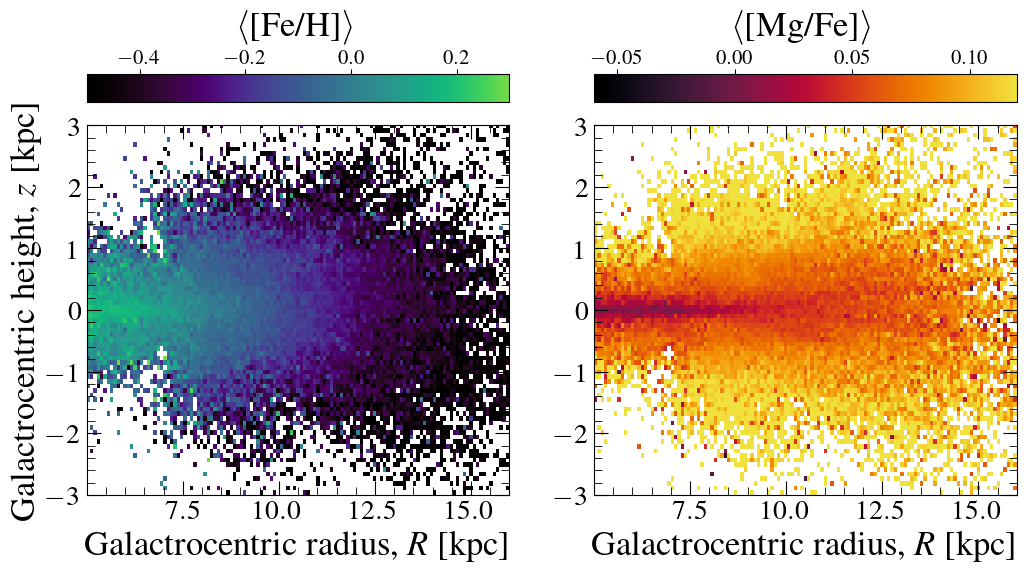

In [63]:
from scipy import stats
mask_R = (Rgal>5)&(Rgal<16)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<100)&lowa_disc_mask&(np.abs(z)<5*u.kpc)
nbins = 128

plt.figure(figsize=(12,6),facecolor='white', rasterized=True)

plt.subplot(1,2,1)
abun = data['FE_H']
binx = np.linspace(np.min(Rgal[mask&(abun>-10)&mask_R]),np.max(Rgal[mask&(abun>-10)&mask_R]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][mask&(abun>-10)&mask_R]),np.max(data['xyz'][:,2][mask&(abun>-10)&mask_R]),nbins)    
hist = stats.binned_statistic_2d(Rgal[mask&(abun>-10)&mask_R],data['xyz'][:,2][mask&(abun>-10)&mask_R], abun[mask&(abun>-10)&mask_R], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender, vmin=-0.5,vmax=0.3)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylim(-3,3)
plt.xlabel('Galactrocentric radius, $R$ [kpc]', fontsize=25)
plt.ylabel('Galactrocentric height, $z$ [kpc]', fontsize=25)
cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(1,2,2)
abun = data['MG_FE']
binx = np.linspace(np.min(Rgal[mask&(abun>-10)&mask_R]),np.max(Rgal[mask&(abun>-10)&mask_R]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][mask&(abun>-10)&mask_R]),np.max(data['xyz'][:,2][mask&(abun>-10)&mask_R]),nbins)    
hist = stats.binned_statistic_2d(Rgal[mask&(abun>-10)&mask_R],data['xyz'][:,2][mask&(abun>-10)&mask_R], abun[mask&(abun>-10)&mask_R], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember, vmin=-0.06,vmax=0.12)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylim(-3,3)
plt.xlabel('Galactrocentric radius, $R$ [kpc]', fontsize=25)
cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-Rz.pdf',dpi=250, bbox_inches = 'tight')


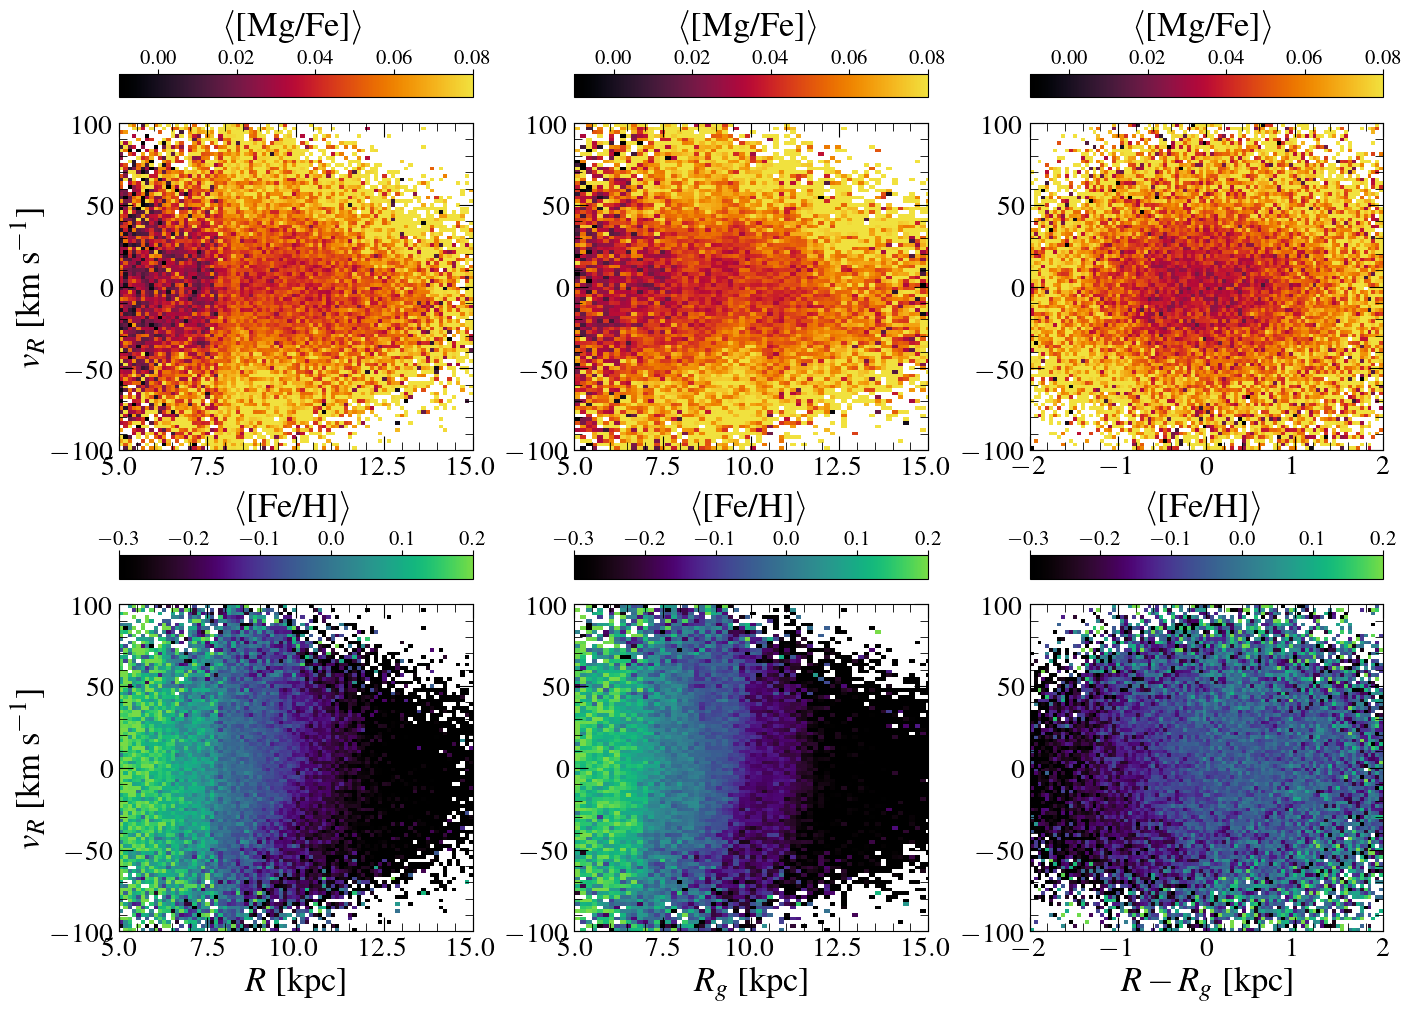

In [62]:
nbins=91
stat='mean'
fig = plt.figure(figsize=(14,10),constrained_layout=True,facecolor='white')
# mask_plot = (Rg>7.775)&(Rg<8.775)
abun = data['MG_FE']

plt.subplot(2,3,1)
binx = np.linspace(np.min(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.01,vmax=0.08)
plt.xlim(5,15)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylabel('$v_R$ [km s$^{-1}$]', fontsize=25)

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(2,3,2)
binx = np.linspace(np.min(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.01,vmax=0.08)
plt.xlim(5,15)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(2,3,3)
binx = np.linspace(np.min(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.01,vmax=0.08)
plt.xlim(-2,2)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


abun = data['FE_H']
plt.subplot(2,3,4)
binx = np.linspace(np.min(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(Rgal[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=-0.3,vmax=0.2)
plt.xlim(5,15)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('$R$ [kpc]', fontsize=25)
plt.ylabel('$v_R$ [km s$^{-1}$]', fontsize=25)

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(2,3,5)
binx = np.linspace(np.min(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(Rg[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=-0.3,vmax=0.2)
plt.xlim(5,15)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('$R_g$ [kpc]', fontsize=25)

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(2,3,6)
binx = np.linspace(np.min(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)
biny = np.linspace(np.min(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),np.max(vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)]),nbins)    
hist = stats.binned_statistic_2d(deltaR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)],vR[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], abun[wmask&(abun>-10)&(Rgal>5)&(Rgal<16)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=-0.3,vmax=0.2)
plt.xlim(-2,2)
plt.ylim(-100,100)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('$R-R_g$ [kpc]', fontsize=25)

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-young-R-Rg-deltaRvR.pdf',dpi=250, bbox_inches = 'tight')


In [ ]:
binsss = np.linspace(5,15,11)
delta = binsss[2]-binsss[0]
bins = []

for indx, i in enumerate(binsss[:-1]):
    mask = (Rg>i)&(Rg<i+delta)&wmask
    print(i, i+delta)
    bins.append(mask)

2.0
5.0 7.0
6.0 8.0
7.0 9.0
8.0 10.0
9.0 11.0
10.0 12.0
11.0 13.0
12.0 14.0
13.0 15.0
14.0 16.0


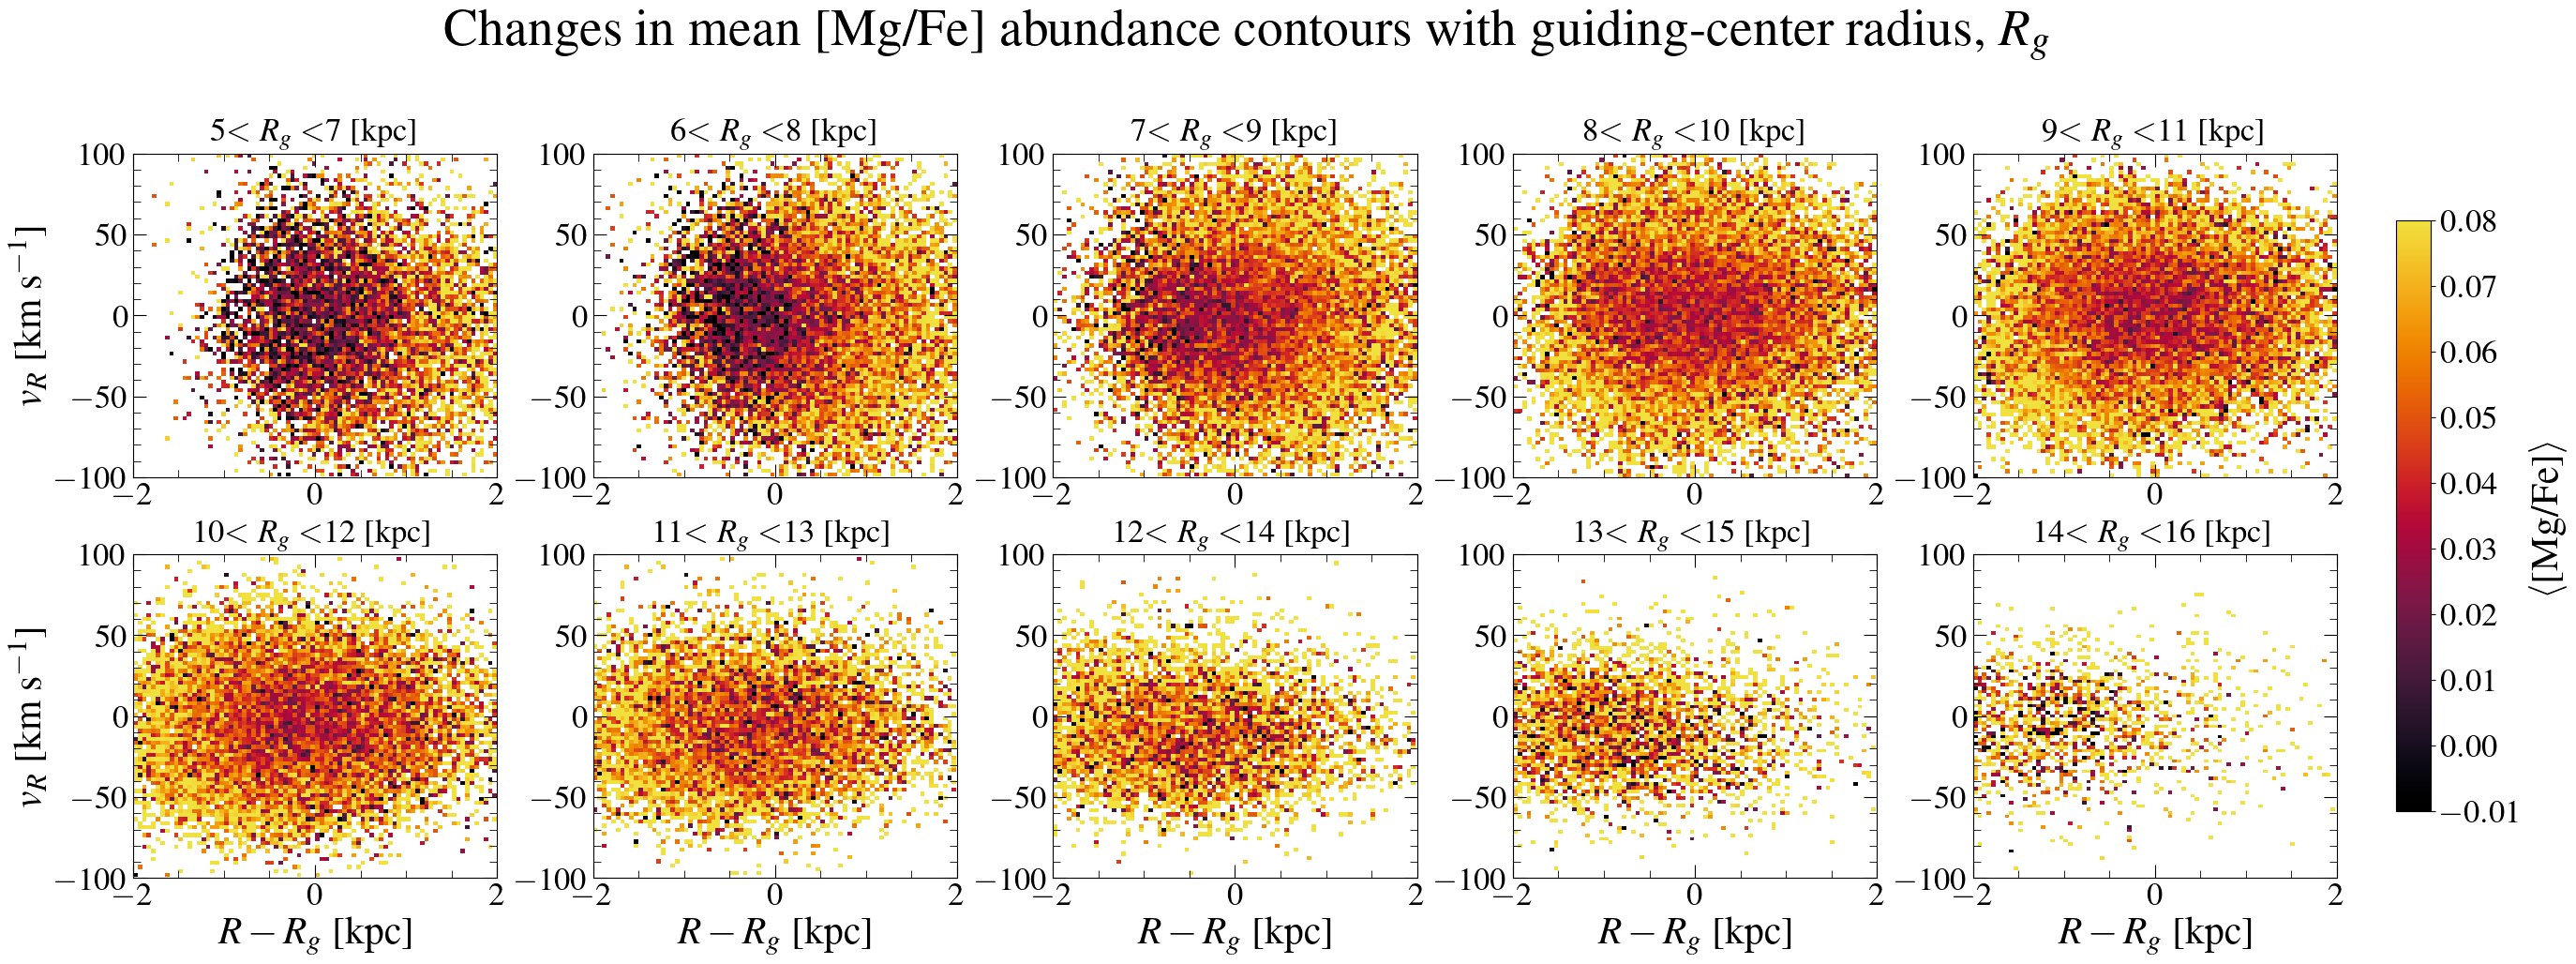

In [76]:
binsss = np.linspace(5,15,11)
delta = binsss[2]-binsss[0]
bins = []

for indx, i in enumerate(binsss[:-1]):
    mask = (Rg>i)&(Rg<i+delta)&wmask
    bins.append(mask)

nbins=81
stat='mean'
fig, all_axes = plt.subplots(2,int(len(bins)/2),figsize=(25,9),constrained_layout=True,facecolor='white')
fig.suptitle('Changes in mean [Mg/Fe] abundance contours with guiding-center radius, $R_g$',fontsize=40,x=0.53,y=1.125)
rgs = binsss

for indx, i in enumerate(bins[:len(bins)]):
    plt.subplot(2,int(len(bins)/2),indx+1)
    abun = data['MG_FE']
    plt.title(str(round(binsss[indx]))+r'$<$ $R_g$ $<$'+str(round(binsss[indx]+delta))+' [kpc]',fontsize=25,pad=10)
    binx = np.linspace(np.min(deltaR[wmask&(abun>-10)&i]),np.max(deltaR[wmask&(abun>-10)&i]),nbins)
    biny = np.linspace(np.min(vR[wmask&(abun>-10)&i]),np.max(vR[wmask&(abun>-10)&i]),nbins)    
    hist = stats.binned_statistic_2d(deltaR[wmask&(abun>-10)&i],vR[wmask&(abun>-10)&i], abun[wmask&(abun>-10)&i], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.01,vmax=0.08,rasterized=True)
#     plt.ylabel('$z$ [kpc]', fontsize=25)
    plt.xlim(-2,2)
    plt.ylim(-100,100)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

cbar_ax = fig.add_axes([1.02, 0.175, 0.015,0.7])
cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


all_axes[0,0].set_ylabel('$v_R$ [km s$^{-1}$]',fontsize=30)
all_axes[1,0].set_ylabel('$v_R$ [km s$^{-1}$]',fontsize=30)
for indx, i in enumerate(all_axes[1,:]):
    i.set_xlabel('$R - R_g$ [kpc]', fontsize=30)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/deltaR-vR-Rgbins.pdf',dpi=250, bbox_inches = 'tight')


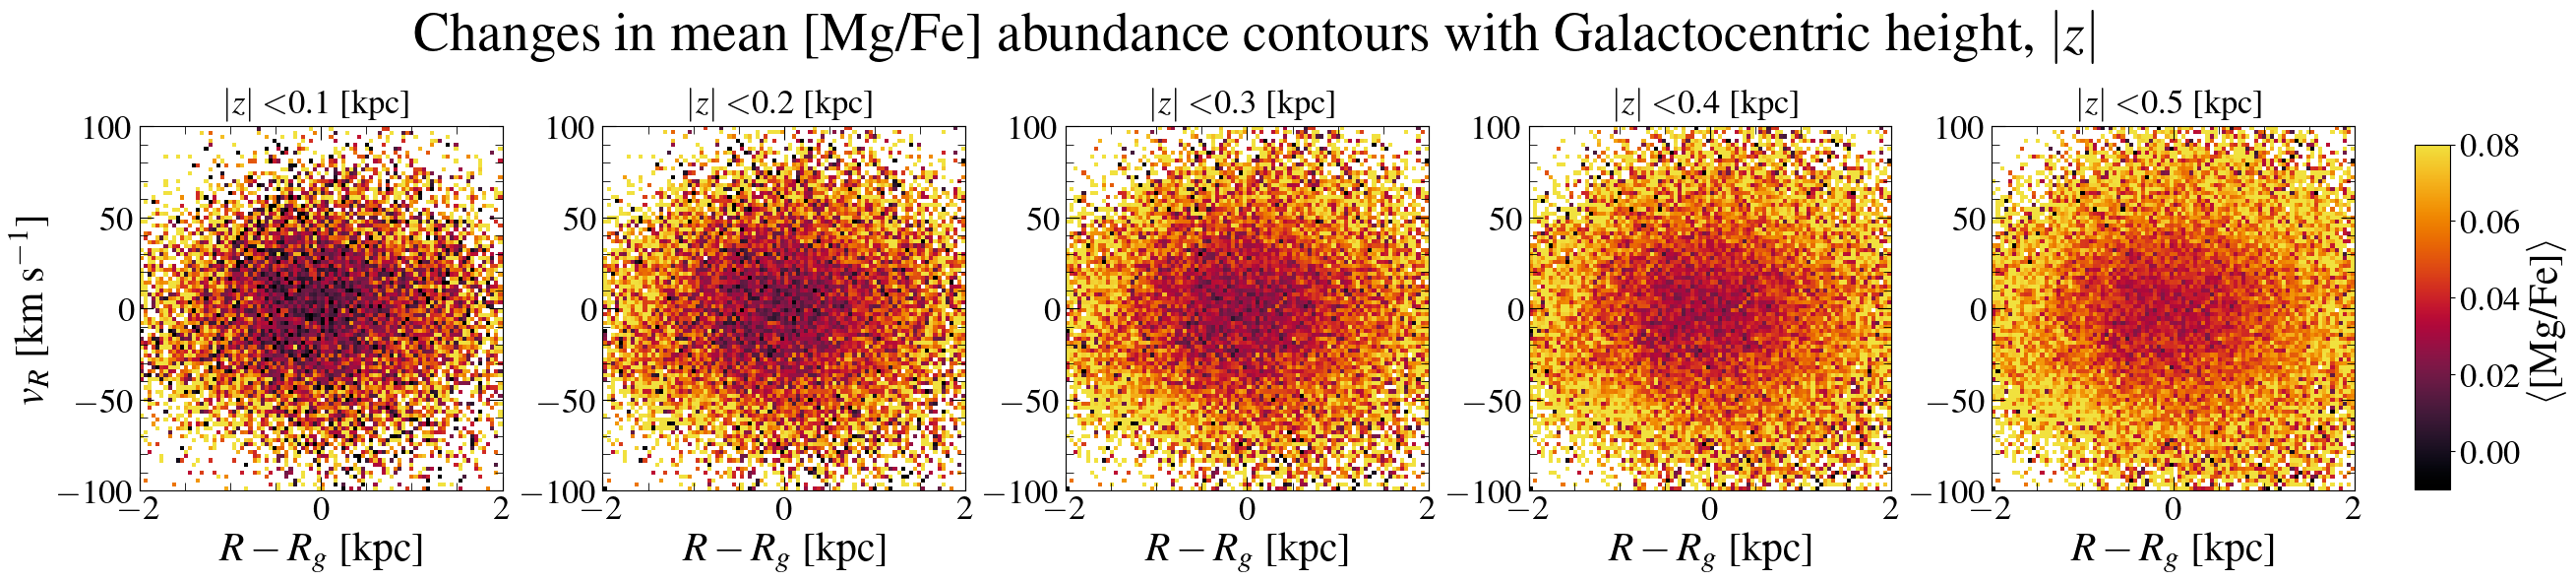

In [80]:
binsss = np.linspace(0.1,0.5,5)

bins = []

for indx, i in enumerate(binsss):
    mask = np.abs(data['xyz'][:,2])<i
    bins.append(mask)

nbins=91
stat='mean'
fig, all_axes = plt.subplots(1,int(len(bins)),figsize=(24,5),constrained_layout=True,facecolor='white')
fig.suptitle('Changes in mean [Mg/Fe] abundance contours with Galactocentric height, $|z|$',fontsize=40,x=0.53,y=1.15)
rgs = binsss

for indx, i in enumerate(bins[:len(bins)]):
    plt.subplot(1,int(len(bins)),indx+1)
    abun = data['MG_FE']
    plt.title('$|z|<$'+str(round(binsss[indx],2))+' [kpc]',fontsize=25,pad=10)
    binx = np.linspace(np.min(deltaR[wmask&(abun>-10)&i]),np.max(deltaR[wmask&(abun>-10)&i]),nbins)
    biny = np.linspace(np.min(vR[wmask&(abun>-10)&i]),np.max(vR[wmask&(abun>-10)&i]),nbins)    
    hist = stats.binned_statistic_2d(deltaR[wmask&(abun>-10)&i],vR[wmask&(abun>-10)&i], abun[wmask&(abun>-10)&i], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.01,vmax=0.08,rasterized=True)
#     plt.ylabel('$z$ [kpc]', fontsize=25)
    plt.xlim(-2,2)
    plt.ylim(-100,100)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

cbar_ax = fig.add_axes([1.02, 0.175, 0.015,0.7])
cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


# all_axes[0].set_ylabel('$v_R$ [km s$^{-1}$]',fontsize=30)
all_axes[0].set_ylabel('$v_R$ [km s$^{-1}$]',fontsize=30)
for indx, i in enumerate(all_axes):
    i.set_xlabel('$R - R_g$ [kpc]', fontsize=30)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/deltaR-vR-zbins.pdf',dpi=250, bbox_inches = 'tight')
